##  Data Loading & Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

In [2]:
dataset=pd.read_csv("pupil_raw_merged.csv")
print(dataset.head())

   subjectID  trialID      time     stimulus  pupil_diameter    class
0          1        1  0.010234  no_stimulus        1.883395  Patient
1          1        1  0.019125  no_stimulus        1.749996  Patient
2          1        1  0.028648  no_stimulus        1.736700  Patient
3          1        1  0.039063  no_stimulus        1.718723  Patient
4          1        1  0.049582  no_stimulus        1.702478  Patient


In [3]:
random_subject=random.choice(dataset['subjectID'].unique())
print(f"Randomly selected subject ID: {random_subject}")
df_subject=dataset[dataset['subjectID']==random_subject]
print(df_subject.head())

Randomly selected subject ID: 98
        subjectID  trialID      time     stimulus  pupil_diameter    class
883084         98        1  0.008041  no_stimulus        1.536370  Healthy
883085         98        1  0.017499  no_stimulus        1.505202  Healthy
883086         98        1  0.026604  no_stimulus        1.609152  Healthy
883087         98        1  0.036213  no_stimulus        1.622279  Healthy
883088         98        1  0.044612  no_stimulus        1.644183  Healthy


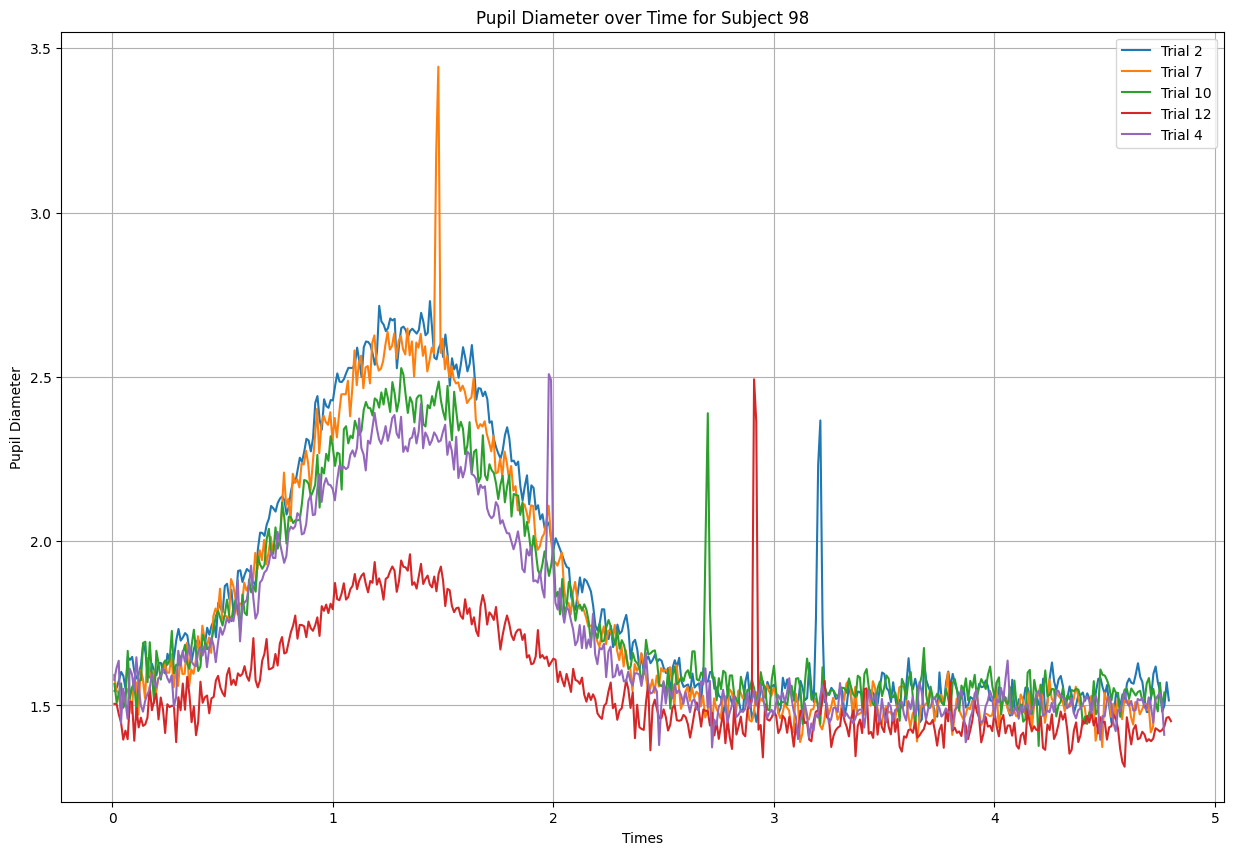

 trialID  Min  Max  Mean  Median  Std  Variance  Count
       2 1.45 2.73  1.83    1.63 0.39      0.15    479
       4 1.37 2.51  1.72    1.56 0.30      0.09    477
       7 1.37 3.44  1.79    1.57 0.39      0.15    475
      10 1.38 2.53  1.78    1.61 0.31      0.10    477
      12 1.31 2.49  1.56    1.49 0.17      0.03    480


In [9]:
trial_ids=df_subject['trialID'].dropna().unique()
trial_ids=np.random.choice(trial_ids, size=5,replace=False)

plt.figure(figsize=(15,10))
for tid in trial_ids:
    df_t=df_subject[df_subject['trialID']==tid]

    plt.plot(df_t['time'], df_t['pupil_diameter'], label=f'Trial {tid}')
plt.xlabel('Times')
plt.ylabel('Pupil Diameter')
plt.title(f'Pupil Diameter over Time for Subject {random_subject}')
plt.legend()
plt.grid(True)
plt.show()



summary=(
        df_subject[df_subject['trialID'].isin(trial_ids)].groupby('trialID')['pupil_diameter']
        .agg(
            Min='min',
            Max='max',
            Mean='mean',
            Median='median',
            Std='std',
            Variance='var',
            Count='count'
        )
        .reset_index()
    )

summary=summary.round(2)
print(summary.to_string(index=False))
x_=trial_ids


In [11]:
df=dataset.dropna(subset=['time','pupil_diameter'])

def sampling_stats(g: pd.DataFrame) -> pd.Series:
    t = g["time"].to_numpy(dtype=float)
    dt = np.diff(t)
    dt_mean = float(np.mean(dt))
    dt_std  = float(np.std(dt))
    coefvar = dt_std / (dt_mean + 1e-12)   # coefficient of variation
    return pd.Series({"n": len(t), "dt_mean": dt_mean, "dt_std": dt_std, "coefvar": coefvar})

# one row per (subjectID, trialID)
rate_table = (
    df.groupby(["subjectID", "trialID"], sort=True)
      .apply(sampling_stats)
      .reset_index()
      .sort_values(["subjectID", "trialID"])
)

print(rate_table.head(5))

# Flag non-uniform trials (tune threshold as needed)
# e.g., coefvar > 0.05 means dt varies more than 5%
non_uniform = rate_table[rate_table["coefvar"] > 0.05]
print("\nNon-uniform trials (coefvar > 0.05):")
print(non_uniform.head(5).to_string(index=False))

   subjectID  trialID      n  dt_mean        dt_std       coefvar
0          1        1  479.0     0.01  2.328420e-16  2.328420e-14
1          1        2  479.0     0.01  2.282448e-16  2.282448e-14
2          1        3  479.0     0.01  3.621610e-16  3.621610e-14
3          1        4  477.0     0.01  2.674545e-16  2.674545e-14
4          1        5  480.0     0.01  2.755062e-16  2.755062e-14

Non-uniform trials (coefvar > 0.05):
Empty DataFrame
Columns: [subjectID, trialID, n, dt_mean, dt_std, coefvar]
Index: []


C:\Users\nimne\AppData\Local\Temp\ipykernel_7560\2408902270.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sampling_stats)


In [12]:
from typing import Tuple



FS=100.0
DT=1.0/FS

In [13]:
from scipy.interpolate import interp1d

def resample_trial(trial: pd.DataFrame, fs: float=FS) -> pd.DataFrame:
    trial_cp = trial.sort_values("time").copy()
    t=trial_cp["time"].to_numpy(dtype=float)
    y=trial_cp["pupil_diameter"].to_numpy(dtype=float)

    t0,t1=float(t.min()), float(t.max())
    if not np.isfinite(t0) or not np.isfinite(t1) or t1 <= t0:
        return trial_cp
    new_t = np.arange(t0, t1+0.5/fs, 1.0/fs)

    mask=np.isfinite(y)
    if np.sum(mask) >= 2:
        f=interp1d(t[mask], y[mask], kind="linear", bounds_error=False, fill_value="extrapolate")
        new_y=f(new_t)
    else:
        new_y=np.full_like(new_t, np.nan, dtype=float)
    
    output=pd.DataFrame({
        "subjectID": trial["subjectID"].iloc[0],
        "trialID":   trial["trialID"].iloc[0],
        "time":      new_t,
        "pupil_diameter": new_y,
    })

    if "class"  in trial.columns:
        output["class"] = trial["class"].iloc[0]
    
    return output



In [14]:
resampled=(
    df.groupby(["subjectID", "trialID"], sort=False,group_keys=False)
      .apply(resample_trial, fs=FS)
      .reset_index(drop=True)
)
print(resampled.head(5))

   subjectID  trialID      time  pupil_diameter    class
0          1        1  0.010234        1.883395  Patient
1          1        1  0.020234        1.748448  Patient
2          1        1  0.030234        1.733964  Patient
3          1        1  0.040234        1.716915  Patient
4          1        1  0.050234        1.705128  Patient


C:\Users\nimne\AppData\Local\Temp\ipykernel_7560\3372211947.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resample_trial, fs=FS)


In [15]:
resampled.to_csv("pupil_resampled.csv", index=False)
dts = (resampled
       .sort_values(["subjectID","trialID","time"])
       .groupby(["subjectID","trialID"])["time"]
       .apply(lambda s: np.diff(s.to_numpy()))
       .explode()             # turn arrays into rows
       .astype(float))        # now it's a simple 1D Series

print("Mean Δt:", dts.mean(), "Std Δt:", dts.std())

Mean Δt: 0.010000000000000002 Std Δt: 2.1267871881299103e-16


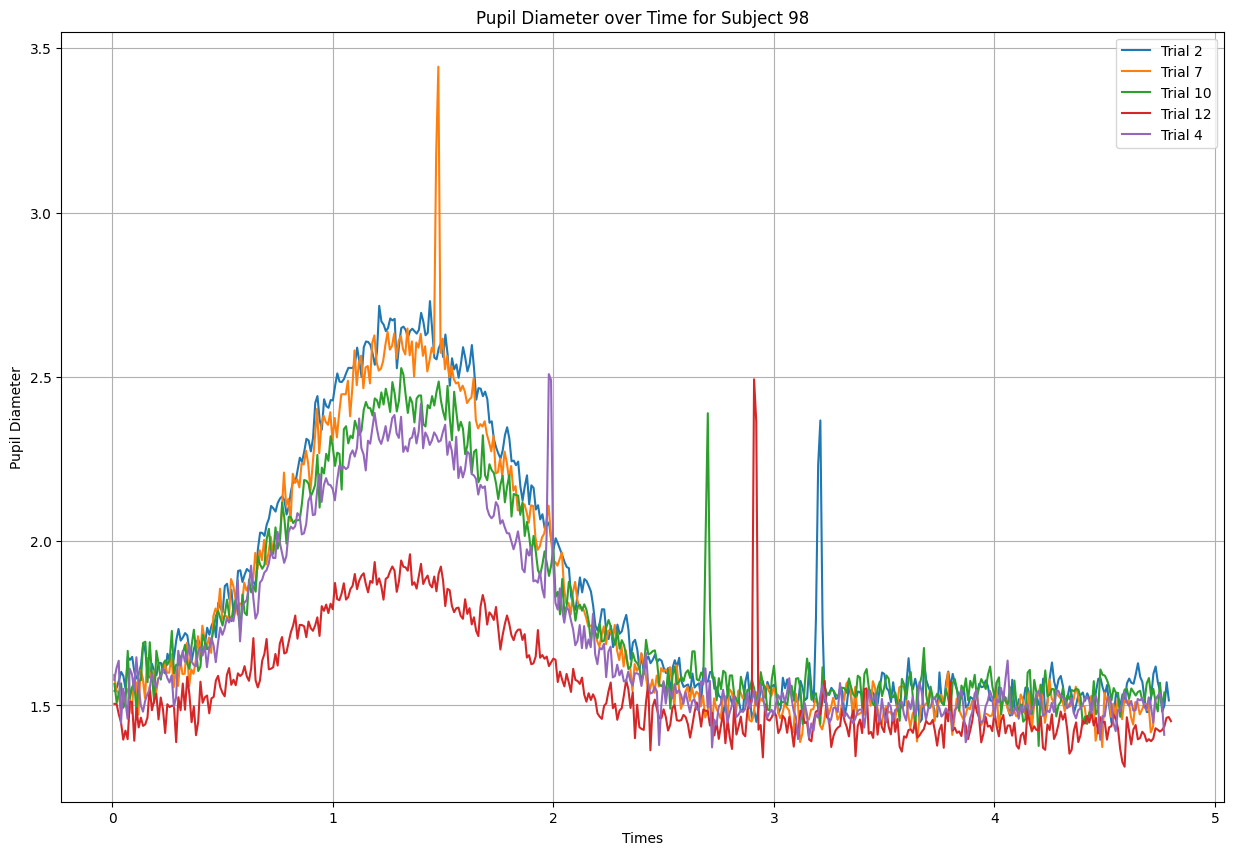

In [16]:
dataset=pd.read_csv("pupil_resampled.csv")
df_subject=dataset[dataset['subjectID']==random_subject]


trial_ids=df_subject['trialID'].dropna().unique()
trial_ids=np.random.choice(trial_ids, size=5,replace=False)

trial_ids=x_

plt.figure(figsize=(15,10))
for tid in trial_ids:
    df_t=df_subject[df_subject['trialID']==tid]

    plt.plot(df_t['time'], df_t['pupil_diameter'], label=f'Trial {tid}')
plt.xlabel('Times')
plt.ylabel('Pupil Diameter')
plt.title(f'Pupil Diameter over Time for Subject {random_subject}')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\nimne\AppData\Local\Temp\ipykernel_29764\1627559787.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_filled=pd.Series(y_clean).fillna(method='ffill').fillna(method='bfill').to_numpy()
C:\Users\nimne\AppData\Local\Temp\ipykernel_29764\1627559787.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_filled=pd.Series(y_clean).fillna(method='ffill').fillna(method='bfill').to_numpy()
C:\Users\nimne\AppData\Local\Temp\ipykernel_29764\1627559787.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_filled=pd.Series(y_clean).fillna(method='ffill').fillna(method='bfill').to_numpy()
C:\Users\nimne\AppData\Local\Temp\ipykernel_29764\1627559787.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will ra

✅ Saved cleaned dataset → pupil_resampled_100Hz_clean.csv


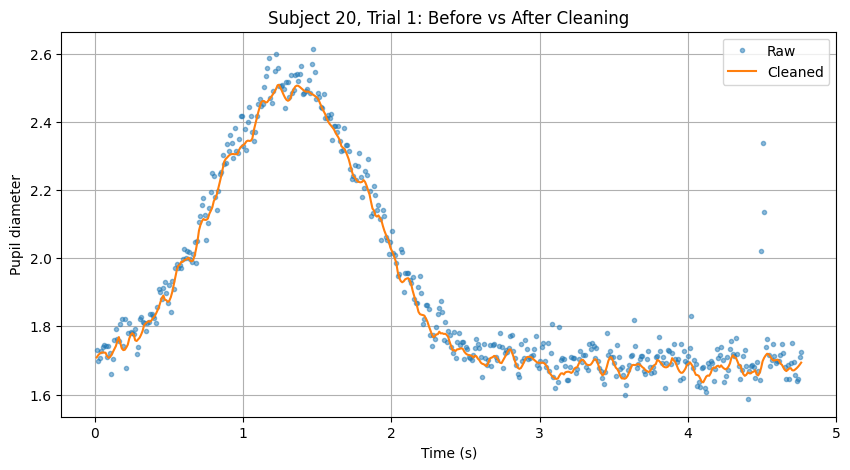

In [23]:
from scipy.signal import savgol_filter
from scipy.stats import norm

def smooth_trial(
        trial_df: pd.DataFrame,
        fs: int = 100,
        window_length: int = 11,
        z_treshold: float = 6.0,
        max_gaps: int = 0.5,
        sg_window: int = 11,
        sg_poly: int = 2

)->pd.DataFrame:
    
    y=trial_df['pupil_diameter'].astype(float)
    n=len(y)
    if n<5:
        out=trial_df.copy()
        out['pupil_clean']=y
        return out
    
    # Rolling median to identify outliers
    y_med=y.rolling(window=window_length, center=True, min_periods=1).median()
    mad=y.rolling(window=window_length, center=True, min_periods=1).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    
    q75=norm.ppf(0.75)
    robust_sigma=(1/q75).round(4)*mad.replace(0,np.nan)

    residual=(y - y_med)/robust_sigma
    spike_mask=residual>(z_treshold*robust_sigma)
    spike_mask=spike_mask.fillna(False)

    y_masked=y.mask(spike_mask,other=np.nan)

    max_gap=int(max_gaps*fs)
    y_interp=y_masked.interpolate(method='linear', limit=max_gap, limit_direction='both')
    y_clean=y_interp.to_numpy()

    if np.isfinite(y_clean).sum() >= sg_window:
        y_filled=pd.Series(y_clean).fillna(method='ffill').fillna(method='bfill').to_numpy()
        y_smooth=savgol_filter(y_filled, window_length=sg_window, polyorder=sg_poly)

    out=trial_df.copy()
    out['pupil_clean']=y_smooth

    return out


def clean_dataset(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    parts = []
    for (sid, tid), g in df.groupby(["subjectID","trialID"], sort=True):
        parts.append(smooth_trial(g, **kwargs))
    return pd.concat(parts, ignore_index=True)    

if __name__ == "__main__":
    IN_FILE = "pupil_resampled.csv"
    OUT_FILE = "pupil_resampled_100Hz_clean.csv"

    # Load
    df = (pd.read_csv(IN_FILE)
            .dropna(subset=["time","pupil_diameter"])
            .sort_values(["subjectID","trialID","time"]))

    # Clean
    df_clean = clean_dataset(
        df,
        fs=100,
        window_length=11,
        z_treshold=6.0,
        max_gaps=0.5,
        sg_window=11,
        sg_poly=2
    )

    # Save
    df_clean.to_csv(OUT_FILE, index=False)
    print(f"✅ Saved cleaned dataset → {OUT_FILE}")

    # Quick before/after plot
    key = df[["subjectID","trialID"]].drop_duplicates().iloc[0]
    sid, tid = 20,1##int(key["subjectID"]), int(key["trialID"])
    raw_t = df[(df["subjectID"]==sid)&(df["trialID"]==tid)]
    clean_t = df_clean[(df_clean["subjectID"]==sid)&(df_clean["trialID"]==tid)]

    plt.figure(figsize=(10,5))
    plt.plot(raw_t["time"], raw_t["pupil_diameter"], ".", alpha=0.5, label="Raw")
    plt.plot(clean_t["time"], clean_t["pupil_clean"], "-", lw=1.5, label="Cleaned")
    plt.xlabel("Time (s)"); plt.ylabel("Pupil diameter")
    plt.title(f"Subject {sid}, Trial {tid}: Before vs After Cleaning")
    plt.legend(); plt.grid(True); plt.show()



In [27]:
import matplotlib.pyplot as plt

def plot_cleaned_trial(df_clean, subject_id=None, trial_id=None):
    """
    Plot only the cleaned signal for one trial.
    If subject_id and trial_id are not given, picks the first available.
    """
    # pick first trial if not specified
    if subject_id is None or trial_id is None:
        key = df_clean[["subjectID","trialID"]].drop_duplicates().iloc[0]
        subject_id, trial_id = int(key["subjectID"]), int(key["trialID"])

    # select trial
    trial = df_clean[(df_clean["subjectID"]==subject_id) & (df_clean["trialID"]==trial_id)]

    # plot cleaned signal
    plt.figure(figsize=(10,5))
    plt.scatter(trial["time"], trial["pupil_diameter"], s=10, alpha=0.5, color="lightblue", label="Cleaned data points")
    plt.plot(trial["time"], trial["pupil_clean"], "-", lw=1.7, color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Pupil diameter (cleaned)")
    plt.title(f"Subject {subject_id}, Trial {trial_id}: Cleaned signal")
    plt.grid(True)
    plt.show()


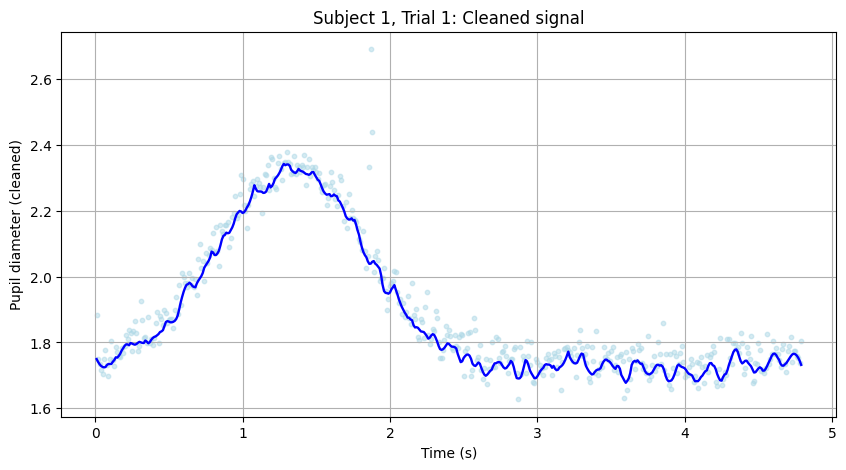

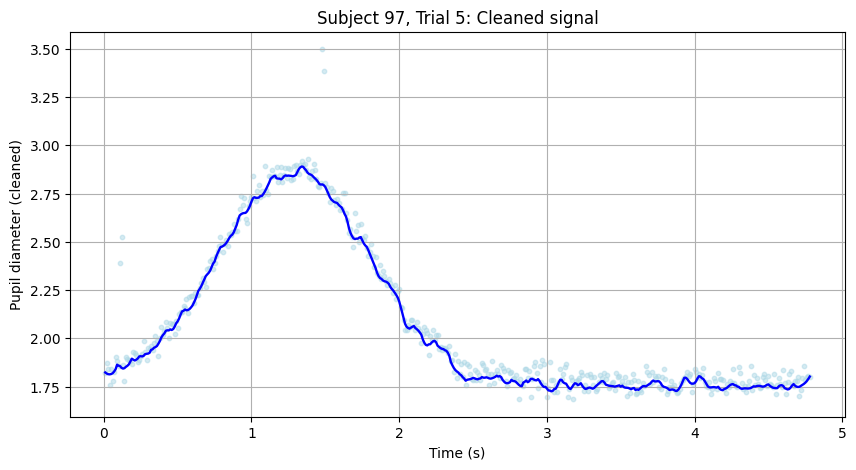

In [28]:
# Plot the first available trial
plot_cleaned_trial(df_clean)

# OR pick a specific trial
plot_cleaned_trial(df_clean, subject_id=97, trial_id=5)


In [26]:
df=pd.read_csv("pupil_resampled_100Hz_clean.csv")
print(df.head())
print(df.columns)

   subjectID  trialID      time  pupil_diameter    class  pupil_clean
0          1        1  0.010234        1.883395  Patient     1.749511
1          1        1  0.020234        1.748448  Patient     1.740768
2          1        1  0.030234        1.733964  Patient     1.733877
3          1        1  0.040234        1.716915  Patient     1.728839
4          1        1  0.050234        1.705128  Patient     1.725653
Index(['subjectID', 'trialID', 'time', 'pupil_diameter', 'class',
       'pupil_clean'],
      dtype='object')
